# Import libraries and Load Data

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report


df = pd.read_excel('seeds.xlsx')
X = df.drop('class', axis=1).values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fisher's LDA Implementation from Scratch

In [67]:
class FisherLDAScratch:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eig_vectors = None
        self.class_means_projected = {} 
        self.classes = None

    def fit(self, X, y):
        n_features = X.shape[1]
        self.classes = np.unique(y)
        
        mean_overall = np.mean(X, axis=0)
        
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))
        
        for c in self.classes:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            
            S_W += (X_c - mean_c).T.dot(X_c - mean_c)
            
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(-1, 1)
            S_B += n_c * (mean_diff).dot(mean_diff.T)
            
        A = np.linalg.pinv(S_W).dot(S_B)
        
        eigenvalues, eigenvectors = np.linalg.eig(A)
        eigenvectors = eigenvectors.T 
        
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvectors = eigenvectors[idxs]
        
        if self.n_components is None:
            self.n_components = len(self.classes) - 1
        self.eig_vectors = eigenvectors[0:self.n_components]
        
        X_projected = np.dot(X, self.eig_vectors.T)
        for c in self.classes:
            self.class_means_projected[c] = np.mean(X_projected[y == c], axis=0)

    def transform(self, X):
        return np.real(np.dot(X, self.eig_vectors.T))

    def predict(self, X):
        X_proj = self.transform(X)
        y_pred = []
        for x_p in X_proj:
            distances = {}
            for c, mean_p in self.class_means_projected.items():
                distances[c] = np.linalg.norm(x_p - mean_p)
            y_pred.append(min(distances, key=distances.get))
        return np.array(y_pred)

# Train and Evaluate Scratch Model

In [68]:
lda_scratch = FisherLDAScratch(n_components=2)
lda_scratch.fit(X_train, y_train)
y_pred_scratch = lda_scratch.predict(X_test)
acc_scratch = np.mean(y_test == y_pred_scratch)


print(f"Accuracy (Scratch): {acc_scratch*100:.2f}%")
print(classification_report(y_test, y_pred_scratch))

Accuracy (Scratch): 88.10%
              precision    recall  f1-score   support

           1       1.00      0.64      0.78        14
           2       0.93      1.00      0.97        14
           3       0.78      1.00      0.88        14

    accuracy                           0.88        42
   macro avg       0.90      0.88      0.87        42
weighted avg       0.90      0.88      0.87        42



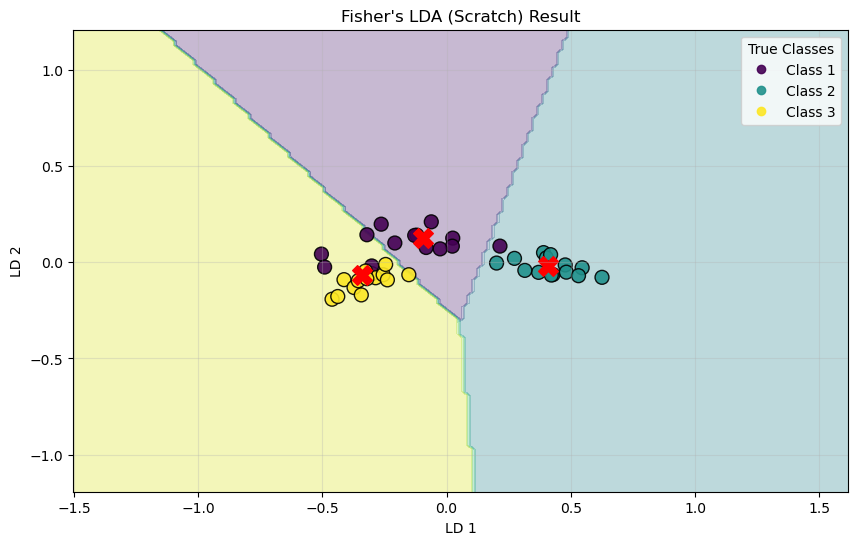

In [69]:
def plot_lda_results(X_2d, y_true, y_pred, title="LDA Projection"):
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    projected_means = {}
    classes = np.unique(y_pred)
    for c in classes:
        projected_means[c] = X_2d[y_pred == c].mean(axis=0)
        
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = []
    for point in mesh_points:
        dists = {c: np.linalg.norm(point - m) for c, m in projected_means.items()}
        Z.append(min(dists, key=dists.get))
    Z = np.array(Z).reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_true, cmap='viridis', edgecolor='k', s=100, alpha=0.9)
    
    for c, m in projected_means.items():
        plt.scatter(m[0], m[1], c='red', marker='X', s=200, label='Centroids' if c==classes[0] else "")
        
    plt.title(title)
    plt.xlabel('LD 1')
    plt.ylabel('LD 2')
    
    handles, _ = scatter.legend_elements()
    class_labels = [f'Class {c}' for c in np.unique(y_true)]
    plt.legend(handles, class_labels, title="True Classes")
    
    plt.grid(True, alpha=0.3)
    plt.show()

X_test_scratch_2d = lda_scratch.transform(X_test)

plot_lda_results(
    X_test_scratch_2d, 
    y_test, 
    y_pred_scratch, 
    title="Fisher's LDA (Scratch) Result"
)

# Scikit-Learn Implementation and Comparison

Scikit-Learn LDA Accuracy: 92.86%
------------------------------
Difference: 4.76%
Result: There is a slight difference (likely due to solver optimization in Sklearn).


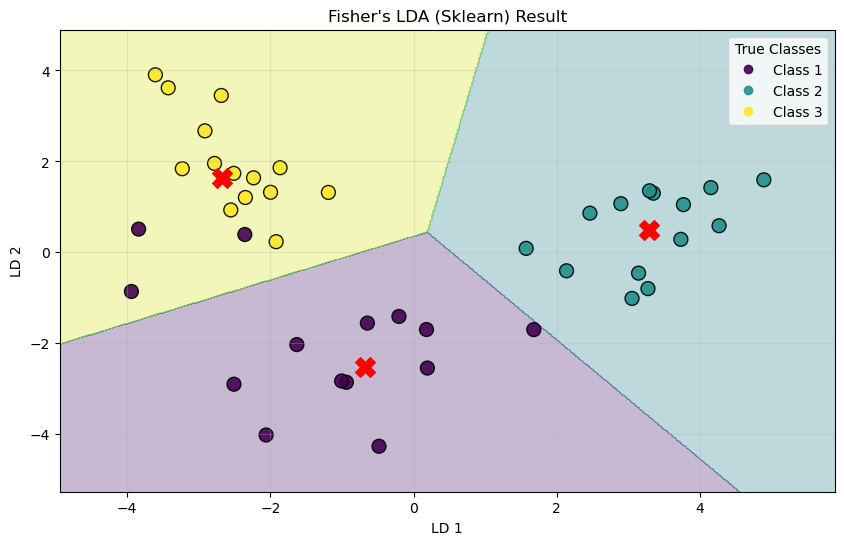

In [70]:
clf_sklearn = LinearDiscriminantAnalysis(store_covariance=True)
clf_sklearn.fit(X_train, y_train)

y_pred_sklearn = clf_sklearn.predict(X_test)

acc_sklearn = np.mean(y_test == y_pred_sklearn)
print(f"Scikit-Learn LDA Accuracy: {acc_sklearn * 100:.2f}%")

print("-" * 30)
print(f"Difference: {abs(acc_scratch - acc_sklearn) * 100:.2f}%")

if acc_scratch == acc_sklearn:
    print("Result: The scratch implementation matches Sklearn perfectly!")
else:
    print("Result: There is a slight difference (likely due to solver optimization in Sklearn).")

X_test_sklearn_2d = clf_sklearn.transform(X_test)

plot_lda_results(
    X_test_sklearn_2d, 
    y_test, 
    y_pred_sklearn, 
    title="Fisher's LDA (Sklearn) Result"
)